In [1]:
'''Helper'''
import pandas as pd
import numpy as np
import time
import joblib
import pickle
import re
import string
import unicodedata
import matplotlib.pyplot as plt
from numpy import argmax
import scipy
# import spacy
from sklearn.metrics.pairwise import cosine_similarity

"""BQ imports"""
from google.cloud import bigquery
client = bigquery.Client()

'''Models'''
from transformers import pipeline
# from onnx_transformers import pipeline # to run this -- downgrade transformers library to 3.2.0

'''Display'''
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option("max_colwidth", 150)

In [2]:
!pip show transformers

Name: transformers
Version: 4.10.3
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Suraj Patil, Stas Bekman, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.7/site-packages
Requires: regex, sacremoses, pyyaml, numpy, huggingface-hub, filelock, packaging, tokenizers, requests, tqdm, importlib-metadata
Required-by: sentence-transformers


### Input data

In [4]:
# df = pd.read_pickle("./data/preprocess_mnet_test.pkl")

# df = pd.read_pickle("./data/mnet_test_tfidf.pkl")

# df = pd.read_pickle("./data/mnet_test_keyphrase.pkl")

df.drop_duplicates('natid', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(1258, 9)


,natid,pub_date,category,tier1,tier2,summary,clean_summary,label,top10_tfidf
0,blogandpostid/blog/post/3541-60eb91d76f189c000...,2021-07-12,Movies,Movies,Indie and Arthouse Movies,What Will The Movie Industry Look Like After C...,movie industry look like covid?. movie industr...,2,"production, customers, future, industry, theat..."
1,blogandpostid/blog/post/7380-5f7a952000e768000...,2020-10-05,Video Gaming,Video Gaming,Video Game Genres,A YouTuber Made An ‘Among Us’ Mode In ‘Overwat...,youtuber us' mode overwatch' looks fantastic. ...,10,"voted, game, code, players, version, korean, u..."
2,blogandpostid/blog/post/50373-5fcfe6475a1f9400...,2020-12-08,News and Politics,News and Politics,Politics,Rudy Giuliani Says He’s ‘Doing Fine’ With Covi...,"rudy giuliani says fine' covid, hopes released...",0,"wednesday, tuesday, house, experiencing, white..."
3,blogandpostid/blog/post/25-607d3d189d9fd30006d...,2021-04-19,Technology and Computing,Personal Finance,Personal Investing,Will Apple Stock’s Q2 Results Beat Consensus?....,apple stock's q2 results beat consensus?. appl...,21,"year, likely, revenue, revenues, fy, margins, ..."
4,blogandpostid/blog/post/6937-60b6f3feff8c53000...,2021-06-02,Movies,Movies,Documentary Movies,Ava DuVernay’s Array Film Collective Partners ...,ava duvernay's array film collective partners ...,2,"pacific, feature, color, independent, festival..."


count     1258
mean      3607
std       2295
min        481
25%       2208
50%       3130
75%       4358
max      39004
Name: clean_summary, dtype: int64

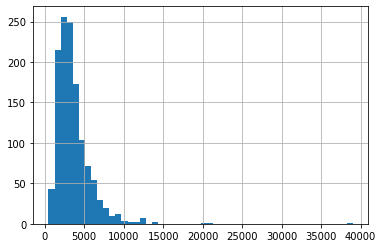

In [4]:
df.clean_summary.str.len().hist(bins=50)
df.clean_summary.str.len().describe().apply(int)

* **Tier 1 labels with tf-idf terms**

In [5]:
new_t1_label = joblib.load("new_t1_label.joblib")
new_t1_label_df = pd.DataFrame.from_dict(new_t1_label, orient='index').reset_index().rename(columns={'index':'tier1', 0:'new_t1_label'})

In [6]:
new_df = pd.merge(df, 
         new_t1_label_df,
         how="left", 
         on="tier1")

In [7]:
new_df.tier1.value_counts().sort_index().sort_index()

Automotive                  49
Books and Literature        17
Business and Finance        50
Careers                     50
Education                   50
Events and Attractions      50
Family and Relationships    49
Fine Art                    25
Food & Drink                48
Healthy Living              49
Hobbies & Interests         48
Home & Garden               47
Medical Health              50
Movies                      49
Music and Audio             49
News and Politics           50
Personal Finance            50
Pets                        17
Pop Culture                 15
Real Estate                 50
Science                     49
Shopping                    49
Sports                      50
Style & Fashion             49
Technology & Computing      50
Television                  49
Travel                      50
Video Gaming                50
Name: tier1, dtype: int64

In [8]:
new_df.new_t1_label.value_counts().sort_index()

Automotive auto sale car electric vehicle                           49
Books & Literature author storyteller fiction read biography        17
Business & Finance consumer marketing yield quarter capital         50
Careers role employee interview skill job                           50
Education college degree enrollment university campus               50
Events & Attractions celebration party parks museum auction         50
Family & Relationships child mother care family custody             49
Fine Art artist photography digital art studio                      25
Food & Drink wine taste cuisine menu restaurant                     48
Healthy Living wellness fitness exercise nutrition mindfulness      49
Hobbies & Interests craft puzzle instrument                         48
Home & Garden interior outdoor remodel appliances renovation        47
Medical Health virus vaccine patient disease outbreak               50
Movies award film theater release documentary                       49
Music 

* **Tier 1 labels with tfidf terms appended to text**

In [5]:
# df["combo_tfidf_summary"] = df["top10_tfidf"] + ' ' + df["clean_summary"]

* **Tier 1 labels with keyphrases**

In [5]:
df["combo_kp_summary"] = df["keyphrases"] + ' ' + df["clean_summary"]

### Generate multi-labels Tier 1 for Test dataset

In [6]:
model = 'joeddav/bart-large-mnli-yahoo-answers'

classifier = pipeline("zero-shot-classification", 
                      model = model, 
                      framework="pt")

candidate_labels = df.tier1.unique().tolist()
print(len(candidate_labels))

# candidate_labels = new_df.new_t1_label.unique().tolist()
# print(len(candidate_labels))

28


In [7]:
prim_labels = []
sec_labels = []
ter_labels = []

prim_scores = []
sec_scores = []
ter_scores = []

begin = 1000 # 800 # 600 # 400 # 200 # 100 # 0  # 1000 #    
end = 1258 # 1000 # 800 # 600 # 400 # 200 # 100 # 1258 #   
df[begin:end]

,natid,pub_date,category,tier1,tier2,summary,clean_summary,label,keyphrases,combo_kp_summary
1000,blogandpostid/blog/post/6582-6063877bd2a8d70006c65e83,2021-04-01,Style and Fashion,Style & Fashion,Women's Fashion,"The Ever Evolving Creativity Of The Engagement Ring, From Small Designers To Renowned Houses.[id=4]<p>The engagement ring has been witnessing a cr...","evolving creativity engagement ring, small designers renowned houses. engagement ring witnessing creative shift unconventional diamonds styling, o...",17,"cluster engagement rings, design rings, customized rings, high diamond jewelry, unconventional diamonds, wedding jewelry, antique jewelry, diamond...","cluster engagement rings, design rings, customized rings, high diamond jewelry, unconventional diamonds, wedding jewelry, antique jewelry, diamond..."
1001,blogandpostid/blog/post/5573-607301537230ca00065220d1,2021-04-11,Sports,Sports,American Football,Michigan’s Jalen Mayfield Would Give The Green Bay Packers Plenty Of Offensive Line Options.[id=0]<p><strong>Note:</strong>&nbsp;The NFL Draft beg...,michigan's jalen mayfield green bay packers plenty offensive line options. note: nfl draft begins april 29 green bay packers 29 th pick round. the...,18,"quality pass rushers, good rushers, nfl power rushers, right tackle, green bays linemen, skinny mayfield, offensive line options, skill set","quality pass rushers, good rushers, nfl power rushers, right tackle, green bays linemen, skinny mayfield, offensive line options, skill set michig..."
1002,blogandpostid/blog/post/3951-5f373d7e363e500006c1ecda,2020-08-14,Sports,Television,Drama TV,WWE Continues To Drop The Ball On A Potential Star In Naomi.[id=17]<p>WWE continues to refuse to learn its lesson about booking babyfaces as Naomi...,wwe continues drop ball potential star naomi. wwe continues refuse learn lesson booking babyfaces naomi quickly trending topic eliminated smackdow...,6,"wwes flawed re-telling, tri-branded battle royal, similar storylines, current storylines, lovable losers, longtime wwe superstar, naomis positioni...","wwes flawed re-telling, tri-branded battle royal, similar storylines, current storylines, lovable losers, longtime wwe superstar, naomis positioni..."
1003,blogandpostid/blog/post/25-610a4b097d0b4e00065a99ca,2021-08-04,Personal Finance,Personal Finance,Personal Investing,"Will Booking Holdings Stock Trend Higher Post Q2?.[id=1]<p><a href=""https://dashboards.trefis.com/data/companies/BKNG"" target=""_blank"" class=""colo...","booking holdings stock trend higher post q2?. booking holdings (nasdaq: bkng) , world's largest online travel agency offers services lodging airli...",21,"holdings stock trend, travel companies, bkng stock comparison, largest online travel agency, consensus estimates, higher post, positive growth res...","holdings stock trend, travel companies, bkng stock comparison, largest online travel agency, consensus estimates, higher post, positive growth res..."
1004,blogandpostid/blog/post/5015-5f9af547a5a5480006298f65,2020-10-29,Personal Finance,Personal Finance,Personal Investing,"Pinterest Stock Soars 30% As Boycotting Advertisers Redirect Spending Away From Facebook, Twitter Over Hate Speech And Bias Concerns.<h2 class=""to...","pinterest stock soars 30% boycotting advertisers redirect spending away facebook, twitter hate speech bias concerns. topline shares post-sharing f...",21,"social media giant facebook, post-sharing firm pinterest, facebook ad boycott, big tech companiesincluding facebook, pinterest stock, social media...","social media giant facebook, post-sharing firm pinterest, facebook ad boycott, big tech companiesincluding facebook, pinterest stock, social media..."
...,...,...,...,...,...,...,...,...,...,...
1253,blogandpostid/blog/post/7321-60f7f7d18050510006289738,2021-07-21,Science,Science,Genetics,"Know The Proteome, Know Yourself - Unlocking The Secrets Of Proteins Could Save Lives.[id=3]<p>From repairing tissues to transporting oxygen in yo...","know prote

In [8]:
start_time = time.time()

art_list = df.combo_kp_summary[begin:end].tolist()

for i in range(len(art_list)):

    res = classifier(art_list[i][:3200], candidate_labels, multi_label=True)
    
    prim_labels.append(res['labels'][0])
    sec_labels.append(res['labels'][1])
    ter_labels.append(res['labels'][2])
    
    prim_scores.append(res['scores'][0])
    sec_scores.append(res['scores'][1])
    ter_scores.append(res['scores'][2])

print("time (mins) - ", round((time.time() - start_time)/60, 2), "\n") 

# runtime: 100 rows - 9 mins (vanilla)
# runtime: 100 rows - 20-25 mins (w/ tfidf+text)
# runtime: 100 rows - 20-25 mins (w/ kp+text)
# runtime: 100 rows - 30 mins (w/ new labels)

time (mins) -  27.91 



In [9]:
ml_data = pd.DataFrame(df[['natid', 'category', 'tier1', 'tier2', 'clean_summary']][begin:end])
ml_data["prim_labels"] = prim_labels
ml_data["sec_labels"] = sec_labels
ml_data["ter_labels"] = ter_labels

ml_data["prim_scores"] = prim_scores
ml_data["sec_scores"] = sec_scores
ml_data["ter_scores"] = ter_scores

In [13]:
# prim_label_mapped = []
# sec_label_mapped = []
# ter_label_mapped = []

# for i in range(len(ml_data)):
    
#     for key, value in new_t1_label.items():
#         if value == prim_labels[i]:
#             prim_label_mapped.append(key)
        
#         if value == sec_labels[i]:
#             sec_label_mapped.append(key)
        
#         if value == ter_labels[i]:
#             ter_label_mapped.append(key)

# ml_data['prim_label_mapped'] = prim_labels
# ml_data['sec_label_mapped'] = sec_labels
# ml_data['ter_label_mapped'] = ter_labels

In [10]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml_data['tier1'])):
    if ml_data['tier1'][i+1000] in (ml_data['prim_labels'] + " " + ml_data['sec_labels'] + " " + ml_data['ter_labels'])[i+1000]:
        match_all.append(True)
    
    if ml_data['tier1'][i+1000] in ml_data['prim_labels'][i+1000]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml_data.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml_data.shape[0])*100))

# tfidf + text = 71-37, 63-33, 66-34, 71-37, 65-30, 73-34, 68-33
# kps + text = 72-35, 62-33, 66-34, 72-36, 67-30, 74-35, 67-33

% rows where Tier1 present in either of three labels -  67
% rows where Tier1 present in prim_labels            -  33


In [11]:
ml_data.to_csv("./mnet_test/ml_kps_text_t1_test_begin_"+str(begin)+".csv", index=False)

* **Analyze results - Tier 1 labels**

* Questions - 
     * zero-shot is good solution but can results be directly consumed for training a classifier? i.e. do all labels make sense?
        * OBS: needs post-processing/filtering to get high confidence ones. 
            * How?
                * filter on basis of similarity of articles which get same labels or
                * ensemble with other method<br><br>
    
    * decide granularity - predict with tier1 and tier2 labels and analyze
        * OBS: works well with more granularity

In [8]:
import glob
import pandas as pd

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

ml = pd_read_pattern('./mnet_test/ml_yahoo_t1_test_begin_*.csv')

# rename
ml.rename(columns = {'prim_scores':'prim_prob', 'sec_scores': 'sec_prob', 'ter_scores':'ter_prob'}, inplace = True)

ml = ml[['natid', 'category', 'clean_summary', 'tier1', 'tier2', 'prim_labels', 'sec_labels', 'ter_labels', 'prim_prob', 'sec_prob', 'ter_prob', ]]
ml.reset_index(drop=True, inplace=True)
print(ml.shape)
print(len(ml.natid.unique()))
print(ml.isna().sum())

(1258, 11)
1258
natid            0
category         0
clean_summary    0
tier1            0
tier2            0
prim_labels      0
sec_labels       0
ter_labels       0
prim_prob        0
sec_prob         0
ter_prob         0
dtype: int64


In [2]:
# ml.to_csv("ml_inspect.csv", index=False)

In [10]:
ml = pd.read_csv("./mnet_test/ml_inspect.csv")

In [11]:
ml.tier1.value_counts()

News and Politics           50
Personal Finance            50
Technology & Computing      50
Medical Health              50
Events and Attractions      50
Education                   50
Careers                     50
Sports                      50
Real Estate                 50
Travel                      50
Video Gaming                50
Business and Finance        50
Movies                      49
Television                  49
Healthy Living              49
Music and Audio             49
Science                     49
Shopping                    49
Automotive                  49
Style & Fashion             49
Family and Relationships    49
Food & Drink                48
Hobbies & Interests         48
Home & Garden               47
Fine Art                    25
Pets                        17
Books and Literature        17
Pop Culture                 15
Name: tier1, dtype: int64

In [12]:
# 36% articles getting Business and Finance

ml.prim_labels.value_counts()

Business and Finance        461
Medical Health              106
Technology & Computing      105
News and Politics            81
Science                      52
Video Gaming                 52
Sports                       49
Healthy Living               41
Music and Audio              36
Food & Drink                 33
Pop Culture                  31
Movies                       27
Travel                       25
Television                   24
Automotive                   19
Shopping                     18
Education                    16
Style & Fashion              12
Careers                      11
Family and Relationships     10
Books and Literature         10
Real Estate                   9
Fine Art                      8
Events and Attractions        8
Personal Finance              6
Hobbies & Interests           4
Home & Garden                 3
Pets                          1
Name: prim_labels, dtype: int64

In [8]:
ml.sec_labels.value_counts()[:10]

Business and Finance      235
Technology & Computing    119
Careers                   113
Healthy Living             91
Personal Finance           82
Pop Culture                68
Real Estate                62
Medical Health             55
Events and Attractions     49
Video Gaming               36
Name: sec_labels, dtype: int64

In [9]:
# 16% articles getting Personal Finance

ml.ter_labels.value_counts()[:10]

Personal Finance          198
Careers                   147
Business and Finance      129
Science                    83
Technology & Computing     77
Events and Attractions     67
Hobbies & Interests        55
Real Estate                54
Pop Culture                50
Healthy Living             36
Name: ter_labels, dtype: int64

In [13]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml['tier1'])):
    if ml['tier1'][i] in (ml['prim_labels'] + " " + ml['sec_labels'] + " " + ml['ter_labels'])[i]:
        match_all.append(True)
    
    if ml['tier1'][i] in ml['prim_labels'][i]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml.shape[0])*100))

% rows where Tier1 present in either of three labels -  68
% rows where Tier1 present in prim_labels            -  34


<AxesSubplot:>

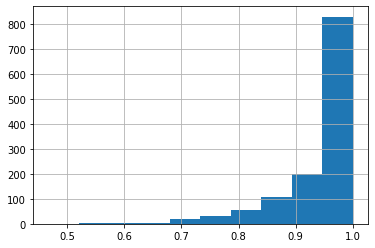

In [11]:
ml.prim_prob.hist()

<AxesSubplot:>

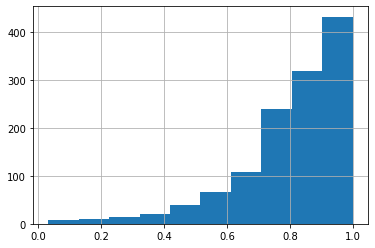

In [12]:
ml.sec_prob.hist()

<AxesSubplot:>

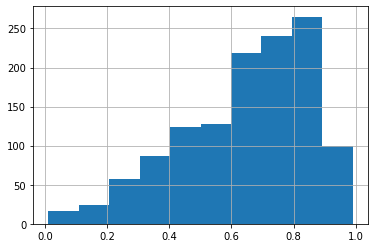

In [13]:
ml.ter_prob.hist()

* **Manual Review**
    * 2 articles per tier randomly sampled
        * OBS: 
            * Tertiary labels are problematic, even ones with high probability - not necessarily error in one specific class only
            * straightforward fitlering on basis of prob not possi

In [17]:
# natid_inspect = list(ml.groupby('tier1').apply(lambda x: x.sample(n=2).squeeze()).natid.unique())
# print(len(natid_inspect))

# joblib.dump(natid_inspect, "natid_manual_review.joblib")

natid_review = joblib.load("./mnet_test/natid_manual_review.joblib")
len(natid_review)

56

In [20]:
ml[ml.natid.isin(natid_review)].tier1.value_counts() #.to_csv("read1.csv", index=False)

Automotive                  2
Travel                      2
Home & Garden               2
Science                     2
News and Politics           2
Television                  2
Shopping                    2
Fine Art                    2
Real Estate                 2
Business and Finance        2
Style & Fashion             2
Personal Finance            2
Books and Literature        2
Music and Audio             2
Events and Attractions      2
Hobbies & Interests         2
Family and Relationships    2
Careers                     2
Healthy Living              2
Movies                      2
Education                   2
Technology & Computing      2
Video Gaming                2
Pets                        2
Sports                      2
Food & Drink                2
Medical Health              2
Pop Culture                 2
Name: tier1, dtype: int64

* **Scalable (non-Manual) filtering**

    * Say, articles X and Y have 1 same label = "Business and Finance". They could still have diff contents and be dissimilar
        * Ex. - X could be "Business and Finance + Sports" and Y could be "Business and Finance + Music" <br><br>

    * But, if they have **3** labels same = they got to have good degree of similarity
        * So, treat 3 labels as a unique combo/group/topic
        * Calculate how similar articles within each combo/group/topic are
        * The combo/group/topic with high cosine similarities can be considered high confidence ones (without reading each article)

In [12]:
# Generate embeddings using avg(sbert)

import joblib
from joblib import Parallel, delayed
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer

def get_embeddings_mod(article_body):
    '''
    For a given article:
    1. Using SentenceTransformer, extracts every sentence's embedding
    2. Averages those embeddings to get one final article-level embedding
    '''
    
    model = SentenceTransformer('all-distilroberta-v1') #distilbert-base-nli-mean-tokens  -- this model is deprecated now 9/9/21
    
    art_sentences = sent_tokenize(article_body)
    
    embedding_sent = model.encode(art_sentences)    

    art_embed = np.mean(embedding_sent, axis=0)
    
    return art_embed

In [13]:
ml_insp = pd.read_csv("ml_inspect.csv")
ml_insp.reset_index(drop=True, inplace=True)

df_proc = ml_insp.clean_summary.tolist()
print("articles: ", len(df_proc))

# Parallel processing

start = time.time()

article_embeddings = Parallel(n_jobs=-1)(delayed(get_embeddings_mod)(article_body) for article_body in df_proc)

print("article_embeddings len:", len(article_embeddings))
print()
print('Embedding generation time {} minutes'.format(round((time.time() - start) / 60, 2)))

articles:  1258
article_embeddings len: 1258

Embedding generation time 3.07 minutes


In [16]:
joblib.dump(article_embeddings, "mnet_test_article_embeddings.joblib")

['mnet_test_article_embeddings.joblib']

In [14]:
article_embeddings = joblib.load("./data/mnet_test_article_embeddings.joblib")

In [15]:
# join 3 labels into a combo/group/topic

ml["label_combo"] = ml["prim_labels"] + " " + ml["sec_labels"] + " " + ml["ter_labels"]

In [16]:
def topic_cos_sim_metrics(embedding_list):
    '''
    a. Calculate cosine similarity of every article (embedding_list) with every other. 
    b. Calculate stats (min, mean etc.) on above
    '''
    
    # convert list to sparse matrix
    sparse_matrix= scipy.sparse.csr_matrix(embedding_list)
    
    # full matrix of cosine similarity of every embedding/article with every other
    cos_mat = cosine_similarity(sparse_matrix)
    
    # keep upper right triangle (above diagonal)
    upper_right = cos_mat[np.triu_indices(len(embedding_list), k=1)]
    
    # calculate metrics
    metrics = pd.DataFrame(upper_right
                          ).describe().T.apply(lambda x: 
                                               round(x, 2)).rename(columns={"min":"cos_min",
                                                                            "mean":"cos_mean",
                                                                            "std":"cos_std", 
                                                                            "50%":"cos_median"})[["cos_min", "cos_mean"]]
    
    return metrics


In [17]:
cossim_matrix_df = pd.DataFrame()
topic_num_list = []

for topic_num in sorted(ml.label_combo.unique()):

    topic_group = ml[ml.label_combo == topic_num]
    # grab all articles of given label combo
    group_embeddings = [article_embeddings[i] for i in list(topic_group.index)]

    # generate cosine similarity metrics for each label combo
    metrics_df = topic_cos_sim_metrics(group_embeddings)

    # append all topic metrics together
    cossim_matrix_df = cossim_matrix_df.append(metrics_df)

    # make a label combo list
    topic_num_list.append(topic_num)

cossim_matrix_df["label_combo"] = topic_num_list

cols = ['label_combo', 'cos_min', 'cos_mean']

cossim_matrix_df = cossim_matrix_df[cols].reset_index(drop=True) #9.56

In [18]:
ml.label_combo.value_counts()

Medical Health Healthy Living Science                       49
Business and Finance Careers Personal Finance               45
Business and Finance Real Estate Personal Finance           42
Business and Finance Personal Finance Real Estate           27
Video Gaming Technology & Computing Hobbies & Interests     25
                                                            ..
Pop Culture Movies Events and Attractions                    1
Food & Drink Events and Attractions Business and Finance     1
Technology & Computing Science Business and Finance          1
Business and Finance Shopping Style & Fashion                1
Food & Drink Business and Finance Travel                     1
Name: label_combo, Length: 501, dtype: int64

In [19]:
vis = cossim_matrix_df[cossim_matrix_df.cos_min.notna()] 

# this shows just the combos having rows > 1
vis

,label_combo,cos_min,cos_mean
0,Automotive Business and Finance Personal Finance,0.1,0.3
1,Automotive Business and Finance Sports,0.1,0.2
5,Automotive Technology & Computing Business and Finance,0.2,0.3
7,Automotive Travel Business and Finance,0.3,0.4
9,Books and Literature Business and Finance Events and Attractions,0.2,0.2
...,...,...,...
495,Video Gaming Technology & Computing Business and Finance,0.0,0.2
496,Video Gaming Technology & Computing Events and Attractions,0.0,0.3
497,Video Gaming Technology & Computing Hobbies & Interests,0.0,0.3
499,Video Gaming Technology & Computing Pop Culture,0.1,0.2


In [20]:
vis.describe()

,cos_min,cos_mean
count,195.0,195.0
mean,0.2,0.3
std,0.1,0.1
min,-0.0,0.1
25%,0.1,0.2
50%,0.2,0.3
75%,0.2,0.3
max,0.7,0.7


<AxesSubplot:>

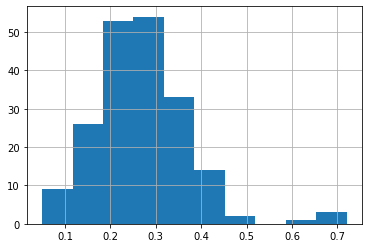

In [20]:
vis.cos_mean.hist()

In [41]:
merged = pd.merge(ml, 
                  cossim_matrix_df, 
                  on='label_combo',
                  how='left')

In [42]:
print(merged[merged.cos_min>0.6].sort_values("label_combo").shape)
print(merged[merged.cos_min>0.5].sort_values("label_combo").shape)
print(merged[merged.cos_mean>=0.4].sort_values("label_combo").shape)

(8, 14)
(10, 14)
(40, 14)


In [46]:
merged[merged.cos_mean>=0.5].sort_values("label_combo").to_csv("read2.csv", index=False)

* **Analyze results - Article text appended with TF-IDF terms in beginning. Orig Tier 1 labels**

In [1]:
import glob
import pandas as pd

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

ml = pd_read_pattern('./mnet_test/ml_tfidf_text_t1_test_begin_*.csv') 

# rename
ml.rename(columns = {'prim_scores':'prim_prob', 'sec_scores': 'sec_prob', 'ter_scores':'ter_prob'}, inplace = True)

ml.reset_index(drop=True, inplace=True)
ml.drop(['prim_label_mapped', 'sec_label_mapped', 'ter_label_mapped'], axis=1, inplace=True)

print(ml.shape)
print(len(ml.natid.unique()))
print(ml.isna().sum())

(1258, 11)
1258
natid            0
category         0
tier1            0
tier2            0
clean_summary    0
prim_labels      0
sec_labels       0
ter_labels       0
prim_prob        0
sec_prob         0
ter_prob         0
dtype: int64


In [2]:
import joblib

natid_review = joblib.load("./mnet_test/natid_manual_review.joblib")
print(len(natid_review))

import numpy as np
ml["Manual Review"] = np.where(ml.natid.isin(natid_review), "Yes", "No")

ml.to_csv("./mnet_test/ml_inspect_tfidf_text_t1.csv", index=False)

56


In [2]:
ml = pd.read_csv("./mnet_test/ml_inspect_tfidf_text_t1.csv")

In [8]:
# 36% get Business and Finance

ml.prim_labels.value_counts()

Business and Finance        450
Technology & Computing      110
Medical Health              105
News and Politics            81
Science                      51
Sports                       50
Video Gaming                 48
Pop Culture                  45
Healthy Living               44
Music and Audio              33
Food & Drink                 32
Travel                       29
Movies                       24
Television                   20
Education                    17
Automotive                   17
Shopping                     16
Events and Attractions       13
Style & Fashion              12
Family and Relationships     11
Books and Literature          9
Hobbies & Interests           9
Real Estate                   8
Fine Art                      8
Personal Finance              7
Careers                       5
Home & Garden                 3
Pets                          1
Name: prim_labels, dtype: int64

In [10]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml['tier1'])):
    if ml['tier1'][i] in (ml['prim_labels'] + " " + ml['sec_labels'] + " " + ml['ter_labels'])[i]:
        match_all.append(True)
    
    if ml['tier1'][i] in ml['prim_labels'][i]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml.shape[0])*100))

% rows where Tier1 present in either of three labels -  68
% rows where Tier1 present in prim_labels            -  34


<AxesSubplot:>

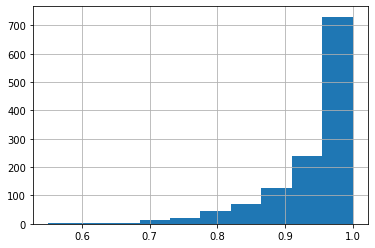

In [11]:
ml.prim_prob.hist()

<AxesSubplot:>

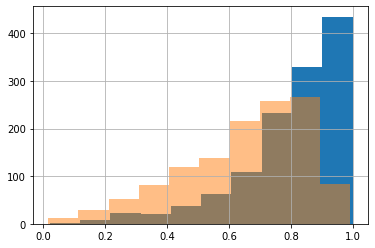

In [12]:
ml.sec_prob.hist()
ml.ter_prob.hist(alpha=0.5)

* **Analyze results - Article text appended with keyphrases in beginning. Orig Tier 1 labels**

In [23]:
import glob
import pandas as pd

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

ml = pd_read_pattern('./mnet_test/ml_kps_text_t1_test_begin_*.csv') 

# rename
ml.rename(columns = {'prim_scores':'prim_prob', 'sec_scores': 'sec_prob', 'ter_scores':'ter_prob'}, inplace = True)

ml.reset_index(drop=True, inplace=True)

print(ml.shape)
print(len(ml.natid.unique()))
print(ml.isna().sum())

(1258, 11)
1258
natid            0
category         0
tier1            0
tier2            0
clean_summary    0
prim_labels      0
sec_labels       0
ter_labels       0
prim_prob        0
sec_prob         0
ter_prob         0
dtype: int64


In [24]:
import joblib

natid_review = joblib.load("./mnet_test/natid_manual_review.joblib")
print(len(natid_review))

import numpy as np
ml["Manual Review"] = np.where(ml.natid.isin(natid_review), "Yes", "No")

ml.to_csv("./mnet_test/ml_inspect_kps_text_t1.csv", index=False)

56


In [25]:
ml = pd.read_csv("./mnet_test/ml_inspect_kps_text_t1.csv")

In [27]:
# 37% got Business and Finance

ml.prim_labels.value_counts()

Business and Finance        471
Technology & Computing      106
Medical Health              104
News and Politics            80
Science                      53
Video Gaming                 52
Sports                       47
Pop Culture                  46
Healthy Living               43
Music and Audio              34
Food & Drink                 33
Travel                       26
Movies                       21
Television                   18
Automotive                   18
Education                    15
Shopping                     15
Style & Fashion              11
Events and Attractions        9
Hobbies & Interests           9
Books and Literature          9
Family and Relationships      9
Real Estate                   8
Careers                       6
Fine Art                      6
Home & Garden                 4
Personal Finance              4
Pets                          1
Name: prim_labels, dtype: int64

In [28]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml['tier1'])):
    if ml['tier1'][i] in (ml['prim_labels'] + " " + ml['sec_labels'] + " " + ml['ter_labels'])[i]:
        match_all.append(True)
    
    if ml['tier1'][i] in ml['prim_labels'][i]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml.shape[0])*100))

% rows where Tier1 present in either of three labels -  69
% rows where Tier1 present in prim_labels            -  34


<AxesSubplot:>

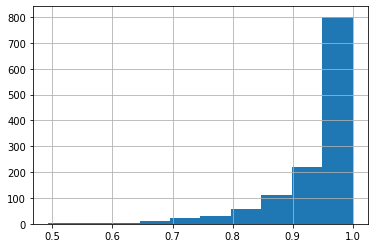

In [29]:
ml.prim_prob.hist()

<AxesSubplot:>

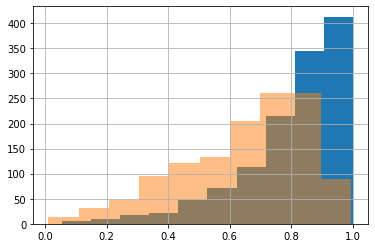

In [30]:
ml.sec_prob.hist()
ml.ter_prob.hist(alpha=0.5)

* **Analyze results - Tier 1 labels appeneded with TF-IDF terms**
    * This was wrong direction

In [17]:
import glob
import pandas as pd

def pd_read_pattern(pattern):
    files = glob.glob(pattern)

    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f))

    return df.reset_index(drop=True)

ml = pd_read_pattern('./mnet_test/ml_yahoo_newlabel_t1_test_begin_*.csv')

# rename
ml.rename(columns = {'prim_scores':'prim_prob', 'sec_scores': 'sec_prob', 'ter_scores':'ter_prob'}, inplace = True)

ml.reset_index(drop=True, inplace=True)
print(ml.shape)
print(len(ml.natid.unique()))
print(ml.isna().sum())

(1258, 14)
1258
natid                0
category             0
tier1                0
tier2                0
clean_summary        0
prim_labels          0
sec_labels           0
ter_labels           0
prim_prob            0
sec_prob             0
ter_prob             0
prim_label_mapped    0
sec_label_mapped     0
ter_label_mapped     0
dtype: int64


In [18]:
import joblib

natid_review = joblib.load("./mnet_test/natid_manual_review.joblib")
print(len(natid_review))

import numpy as np
ml["Manual Review"] = np.where(ml.natid.isin(natid_review), "Yes", "No")

ml.to_csv("./mnet_test/ml_inspect_t1_tfidf_label.csv", index=False)

56


In [22]:
ml = pd.read_csv("./mnet_test/ml_inspect_t1_tfidf_label.csv")

In [17]:
ml.prim_label_mapped.value_counts()

Careers                     288
Business and Finance        212
Technology & Computing      191
Medical Health               83
Real Estate                  65
Personal Finance             61
Television                   52
Healthy Living               52
Music and Audio              37
Science                      33
Education                    31
Sports                       27
Food & Drink                 21
Automotive                   21
Family and Relationships     10
Home & Garden                10
Books and Literature         10
Movies                        9
News and Politics             8
Style & Fashion               7
Pets                          6
Shopping                      5
Pop Culture                   5
Events and Attractions        5
Hobbies & Interests           4
Fine Art                      3
Video Gaming                  1
Travel                        1
Name: prim_label_mapped, dtype: int64

In [24]:
# TIER 1

match_all = []
match_prim = []

for i in range(len(ml['tier1'])):
    if ml['tier1'][i] in (ml['prim_label_mapped'] + " " + ml['sec_label_mapped'] + " " + ml['ter_label_mapped'])[i]:
        match_all.append(True)
    
    if ml['tier1'][i] in ml['prim_label_mapped'][i]:
        match_prim.append(True)
        
print("% rows where Tier1 present in either of three labels - ", round((len(match_all)/ml.shape[0])*100))
print("% rows where Tier1 present in prim_labels            - ", round((len(match_prim)/ml.shape[0])*100))

% rows where Tier1 present in either of three labels -  56
% rows where Tier1 present in prim_labels            -  33


<AxesSubplot:>

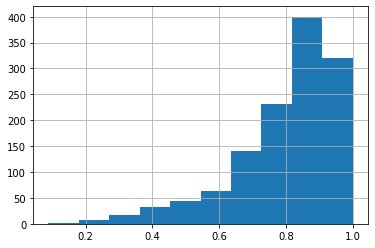

In [6]:
ml.prim_prob.hist()

<AxesSubplot:>

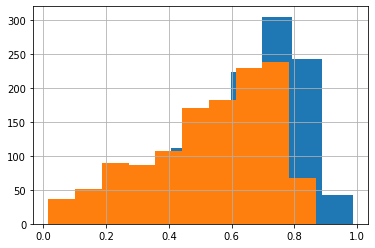

In [7]:
ml.sec_prob.hist()
ml.ter_prob.hist(alpha=0.5)

In [21]:
orig = pd.read_csv("./mnet_test/ml_inspect.csv") 
tf = pd.read_csv("./mnet_test/ml_inspect_tfidf_text_t1.csv")
kps = pd.read_csv("./mnet_test/ml_inspect_kps_text_t1.csv")

In [60]:
orig["orig_combo"] = orig["prim_labels"] + ', ' + orig["sec_labels"] +  ', ' + orig["ter_labels"] 
tf["tf_combo"] = tf["prim_labels"] +  ', ' + tf["sec_labels"] +  ', ' + tf["ter_labels"] 
kps["kps_combo"] = kps["prim_labels"] +  ', ' + kps["sec_labels"] +  ', ' + kps["ter_labels"] 

# combine and sort
orig.orig_combo = orig.orig_combo.apply(lambda x: sorted([x.strip() for x in x.split(',')])).apply(lambda x: ', '.join(x))
tf.tf_combo = tf.tf_combo.apply(lambda x: sorted([x.strip() for x in x.split(',')])).apply(lambda x: ', '.join(x))
kps.kps_combo = kps.kps_combo.apply(lambda x: sorted([x.strip() for x in x.split(',')])).apply(lambda x: ', '.join(x))

In [67]:
test = pd.merge(pd.merge(orig[["natid", "orig_combo"]], 
         tf[["natid", "tf_combo"]], 
         on = "natid", how="inner"), 
         kps[["natid", "kps_combo"]], 
         on="natid", how="inner")
test.shape

(1258, 4)

In [70]:
# 76% articles got same labels

test[test.orig_combo == test.tf_combo].shape

(960, 4)

In [71]:
# 75% articles got same labels 

test[test.orig_combo == test.kps_combo].shape

(944, 4)

In [20]:
# !pip install rank_bm25